# Data Analysis using MongoDB on a Raspberry Pi Cluster

## Key Libraries

For this demonstration we'll be using some popular libraries in the PyData ecosystem.

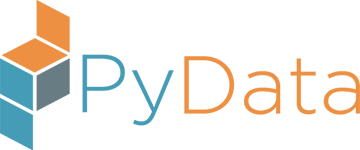

**Jupyter** is a web application for creating and sharing computational documents. It offers a simple, streamlined, document-centric experience.

**Dask** provides multi-core and distributed parallel execution on larger-than-memory datasets.

**Pandas** is a fast, powerful, flexible and easy to use open source data analysis and manipulation tool.

**Apache Arrow** is a cross-language development platform for in-memory analytics.

**Bokeh** is an interactive visualization library for modern web browsers.

For MongoDB integration, we'll use the following libraries:

**pymongo** is a native Python driver for MongoDB.

**pymongoarrow** is a companion library to PyMongo that contains tools for loading MongoDB query result sets as Apache Arrow tables, Pandas DataFrames or NumPy arrays.

## Computing Environment
We'll be running our analytics and our MongoDB cluster on a set of Raspberry Pi mini-computers.

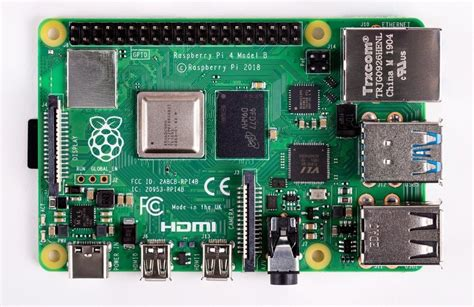

## Data Under Test

Today we analyze some publicly avaiable data about taxi trips in NYC.

Yellow and green taxi trip records include fields capturing pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts.

The data is provided by the NYC Taxi and Limousine Commission and is available in the Parquet file format.

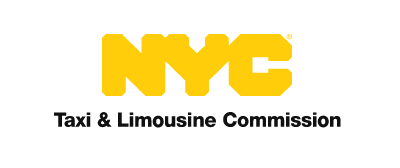

### Read single dataframe from S3 

In [1]:
from s3fs import S3FileSystem

s3 = S3FileSystem(anon=True)
files = s3.ls('nyc-tlc/trip data')
list(name for name in files if 'yellow_tripdata_2021' in name)

['nyc-tlc/trip data/yellow_tripdata_2021-01.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-02.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-03.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-04.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-05.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-06.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-07.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-08.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-09.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-10.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-11.parquet',
 'nyc-tlc/trip data/yellow_tripdata_2021-12.parquet']

### Download the file so we can use it locally

In [2]:
s3.download('nyc-tlc/trip data/yellow_tripdata_2021-01.parquet', 'yellow_tripdata_2021-01.parquet')

[None]

In [3]:
import pandas as pd

with open('./yellow_tripdata_2021-01.parquet', 'rb') as f:
    df = pd.read_parquet(f)
df

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2021-01-01 00:30:10,2021-01-01 00:36:12,1.0,2.10,1.0,N,142,43,2,8.00,3.00,0.5,0.00,0.00,0.3,11.80,2.5,NaN
1,1,2021-01-01 00:51:20,2021-01-01 00:52:19,1.0,0.20,1.0,N,238,151,2,3.00,0.50,0.5,0.00,0.00,0.3,4.30,0.0,NaN
2,1,2021-01-01 00:43:30,2021-01-01 01:11:06,1.0,14.70,1.0,N,132,165,1,42.00,0.50,0.5,8.65,0.00,0.3,51.95,0.0,NaN
3,1,2021-01-01 00:15:48,2021-01-01 00:31:01,0.0,10.60,1.0,N,138,132,1,29.00,0.50,0.5,6.05,0.00,0.3,36.35,0.0,NaN
4,2,2021-01-01 00:31:49,2021-01-01 00:48:21,1.0,4.94,1.0,N,68,33,1,16.50,0.50,0.5,4.06,0.00,0.3,24.36,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1369764,2,2021-01-31 23:03:00,2021-01-31 23:33:00,NaN,8.89,NaN,None,229,181,0,27.78,0.00,0.5,7.46,0.00,0.3,38.54,NaN,NaN
1369765,2,2021-01-31 23:29:00,2021-01-31 23:51:00,NaN,7.43,NaN,None,41,70,0,32.58,0.00,0.5,0.00,6.12,0.3,39.50,NaN,NaN
1369766,2,2021-01-31 23:25:00,2021-01-31 23:38:00,NaN,6.26,NaN,None,74,137,0,16.85,0.00,0.5,3.90,0.00,0.3,24.05,NaN,NaN
1369767,6,2021-01-31 23:01:06,2021-02-01 00:02:03,NaN,19.70,NaN,None,265,188,0,53.68,0.00,0.5,0.00,0.00,0.3,54.48,NaN,NaN


In [4]:
df.dtypes

VendorID                          int64
tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float64
trip_distance                   float64
RatecodeID                      float64
store_and_fwd_flag               object
PULocationID                      int64
DOLocationID                      int64
payment_type                      int64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
congestion_surcharge            float64
airport_fee                     float64
dtype: object

## Cluster Configuration
The cluster consists of XX Raspberry Pis of multiple versions.
Each one is loaded with MongoDB Server Version 4.4 and Python 3.9.

We set up a replicaset comprised of MongoDB servers on each of the Raspberry Pi devices.

The primary node will run on this host.

We manually deployed a local `dask-scheduler` at tcp://192.168.2.1:8001

On each Raspberry Pi we have started a `dask-worker` connecting to the scheduler.

In [6]:
from pymongo import MongoClient
client = MongoClient("192.168.2.1:27017")
client.admin.command('ping')
client.topology_description

<TopologyDescription id: 629b71f033ccbb05853a4d03, topology_type: ReplicaSetWithPrimary, servers: [<ServerDescription ('192.168.2.1', 27017) server_type: RSPrimary, rtt: 0.0011812890006694943>, <ServerDescription ('192.168.2.2', 27017) server_type: Unknown, rtt: None>, <ServerDescription ('192.168.2.3', 27017) server_type: Unknown, rtt: None>]>

### Ingest the Data in to Our Database
While this is loading we can ssh into one of our Raspberry Pis and poke around

In [7]:
from pymongo import MongoClient
from pyarrow.parquet import read_table
from pymongoarrow.api import write
data = read_table("./yellow_tripdata_2022-01.parquet")
coll = client.test.test
#coll.drop()
#write(coll, data)

## Read from the Database

In [8]:
from dask.dataframe import from_pandas
from pyarrow import int64, float64, timestamp
from pymongoarrow.api import Schema
from pymongoarrow.monkey import patch_all
patch_all()

### Query a Subset of the Data Using Aggregation

In [9]:
# Compute average trip distance grouped by passenger count
pipeline = [
    {"$group": {"_id": "$passenger_count", "mean_distance": {"$avg": "$trip_distance" }}},
    {"$sort": {"_id": 1}}
]
df = coll.aggregate_pandas_all(pipeline, schema=Schema({"_id": int, "mean_distance": float}))
df

,_id,mean_distance
0,NaN,81.427125
1,0.0,2.746838
2,1.0,3.015300
3,2.0,3.503723
4,3.0,3.343565
5,4.0,3.486760
6,5.0,3.008710
7,6.0,3.149393
8,7.0,0.792222
9,8.0,0.511250


### Load all the Data into a Dataframe

In [10]:
schema = Schema(dict(
    VendorID=int64(), 
    passenger_count=float64(),
    trip_distance=float64(),
    tip_amount=float64(),
    fare_amount=float64(),
    tpep_pickup_datetime=timestamp('ms')))

df = coll.find_pandas_all({}, schema=schema)
df.head()

,VendorID,passenger_count,trip_distance,tip_amount,fare_amount,tpep_pickup_datetime
0,1,2.0,3.80,3.65,14.5,2022-01-01 00:35:40
1,1,1.0,2.10,4.00,8.0,2022-01-01 00:33:43
2,2,1.0,0.97,1.76,7.5,2022-01-01 00:53:21
3,2,1.0,1.09,0.00,8.0,2022-01-01 00:25:21
4,2,1.0,4.30,3.00,23.5,2022-01-01 00:36:48


### Parallelize with Dask.dataframe

In [11]:
import dask.dataframe as dd
df = dd.from_pandas(df, chunksize=10000)

Dask.distributed is a lightweight library for distributed computing in Python. It extends both the concurrent.futures and dask APIs to moderate sized clusters.

In [12]:
from dask.distributed import Client, progress
dask_client = Client('tcp://192.168.2.1:8001')
dask_client

Connection method: Direct,
Dashboard: http://192.168.2.1:8787/status,
Comm: tcp://192.168.2.1:8001,Workers: 0
Dashboard: http://192.168.2.1:8787/status,Total threads: 0
Started: 10 minutes ago,Total memory: 0 B


In [13]:
df = dask_client.persist(df)
progress(df)

VBox()


Dask DataFrames
---------------

*  Coordinate many Pandas DataFrames across a cluster
*  Faithfully implement a subset of the Pandas API
*  Use Pandas under the hood (for speed and maturity)

In [18]:
df

,VendorID,passenger_count,trip_distance,tip_amount,fare_amount,tpep_pickup_datetime
npartitions=2,,,,,,
0,int64,float64,float64,float64,float64,datetime64[ns]
2077000,...,...,...,...,...,...
2463930,...,...,...,...,...,...


In [19]:
df.dtypes

VendorID                         int64
passenger_count                float64
trip_distance                  float64
tip_amount                     float64
fare_amount                    float64
tpep_pickup_datetime    datetime64[ns]
dtype: object

In [20]:
df.head()

,VendorID,passenger_count,trip_distance,tip_amount,fare_amount,tpep_pickup_datetime
0,1,2.0,3.80,3.65,14.5,2022-01-01 00:35:40
1,1,1.0,2.10,4.00,8.0,2022-01-01 00:33:43
2,2,1.0,0.97,1.76,7.5,2022-01-01 00:53:21
3,2,1.0,1.09,0.00,8.0,2022-01-01 00:25:21
4,2,1.0,4.30,3.00,23.5,2022-01-01 00:36:48


In [21]:
%time len(df)

CPU times: user 13.7 ms, sys: 3.38 ms, total: 17.1 ms
Wall time: 33.1 ms


2463931

In [22]:
%time df.passenger_count.sum().compute()

CPU times: user 13.2 ms, sys: 3.16 ms, total: 16.4 ms
Wall time: 36.5 ms


3324167.0

In [23]:
# Compute average trip distance grouped by passenger count
df.groupby(df.passenger_count).trip_distance.mean().compute()

passenger_count
0.0    2.746838
1.0    3.015300
2.0    3.503723
3.0    3.343565
4.0    3.486760
5.0    3.008710
6.0    3.149393
7.0    0.792222
8.0    0.511250
9.0    9.506667
Name: trip_distance, dtype: float64

### Tip Fraction, grouped by day-of-week and hour-of-day

In [24]:
df2 = df[(df.tip_amount > 0) & (df.fare_amount > 0)]
df2 = df2.assign(tip_fraction=df2.tip_amount / df2.fare_amount)

In [26]:
# Group df.tpep_pickup_datetime by dayofweek and hour
dayofweek = df2.groupby(df2.tpep_pickup_datetime.dt.dayofweek).tip_fraction.mean() 
hour = df2.groupby(df2.tpep_pickup_datetime.dt.hour).tip_fraction.mean()

dayofweek, hour = dask_client.persist([dayofweek, hour])
progress(dayofweek, hour)

VBox()

### Plot results

In [27]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()

fig = figure(title='Tip Fraction',
             x_axis_label='Hour of day',
             y_axis_label='Tip Fraction',
             height=300)
fig.line(x=hour.index.compute(), y=hour.compute(), line_width=3)
fig.y_range.start = 0

show(fig)

Loading BokehJS ...

## Future Improvements
- Improve the speed of data write to MongoDB in pymongoarrow
- Improve integration with dask
  - Read data from Mongo directly into dask dataframe
  - Use local data on workers instead of transporting it